# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS-109A Introduction to Data Science



## Group #20: Final Project - World Cup Predictions 

**Harvard University**<br>
**Fall 2018**<br>
**Group Members:** <br>

In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
sns.set()
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import cross_val_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.utils import resample
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
import warnings

from IPython.display import display

warnings.filterwarnings('ignore')

### Data Preparation

In [ ]:
    
#     # first compute a lowess fit to the data
#     los = lw.lowess(train_data['outcome_num'], train_data[col], frac = 0.3)

#     # now make the plots
#     fig = plt.figure(figsize=(8, 6))
#     fig.clf()
#     ax = fig.gca()
#     df.plot(kind = 'scatter', x = col, y = 'outcome_num', ax = ax, alpha = 0.05)
#     plt.plot(los[:, 0], los[:, 1], axes = ax, color = 'red')
#     ax.set_xlabel(col)
#     ax.set_ylabel('Outcome of the Match')
#     ax.set_title('Outcome of the Match vs. ' + col)

In [3]:
# load the dataset for match results and team ratings
X = pd.read_csv('data/team/final_dataset.csv', index_col='Unnamed: 0')

# check for data types and missing values
#X.info()

In [4]:
# change the Date feature to datetime type
X['date'] = pd.to_datetime(X['date'])


In [5]:
# split data into train and test sets
train_data = X[X['date'] <= '2018-06-13']
test_data = X[X['date'] > '2018-06-13']

### Exploratory Data Analysis

In [6]:
num_cols = ['ATT_diff',     'MID_diff',     'DEF_diff',  
            'ATT_age_diff', 'MID_age_diff', 'DEF_age_diff', 
            'ATT_ht_diff',  'MID_ht_diff',  'DEF_ht_diff', 
            'ATT_wt_diff',  'MID_wt_diff',  'DEF_wt_diff',  
            'diff_hrva_rwma', 'diff_hrvap_rwma', 'diff_hrva_rmean' , 'diff_hrvap_rmean', 
            'hrvo_rwma' , 'hrvop_rwma',
            'rank_pts_diff'
           
           ]

In [ ]:
    
def wc_box(df, cols):
        
    # loop over the columns and create box plots
    for col in cols:
        fig = plt.figure(figsize=(8, 6))
        fig.clf()
        ax = fig.gca()
        ax.boxplot(column = col, by = 'outcome', vert=False, ax = ax)        
        ax.set_xlabel(col)
        ax.set_ylabel('Outcome of the Match')
        ax.set_title('Outcome vs. ' + col)  

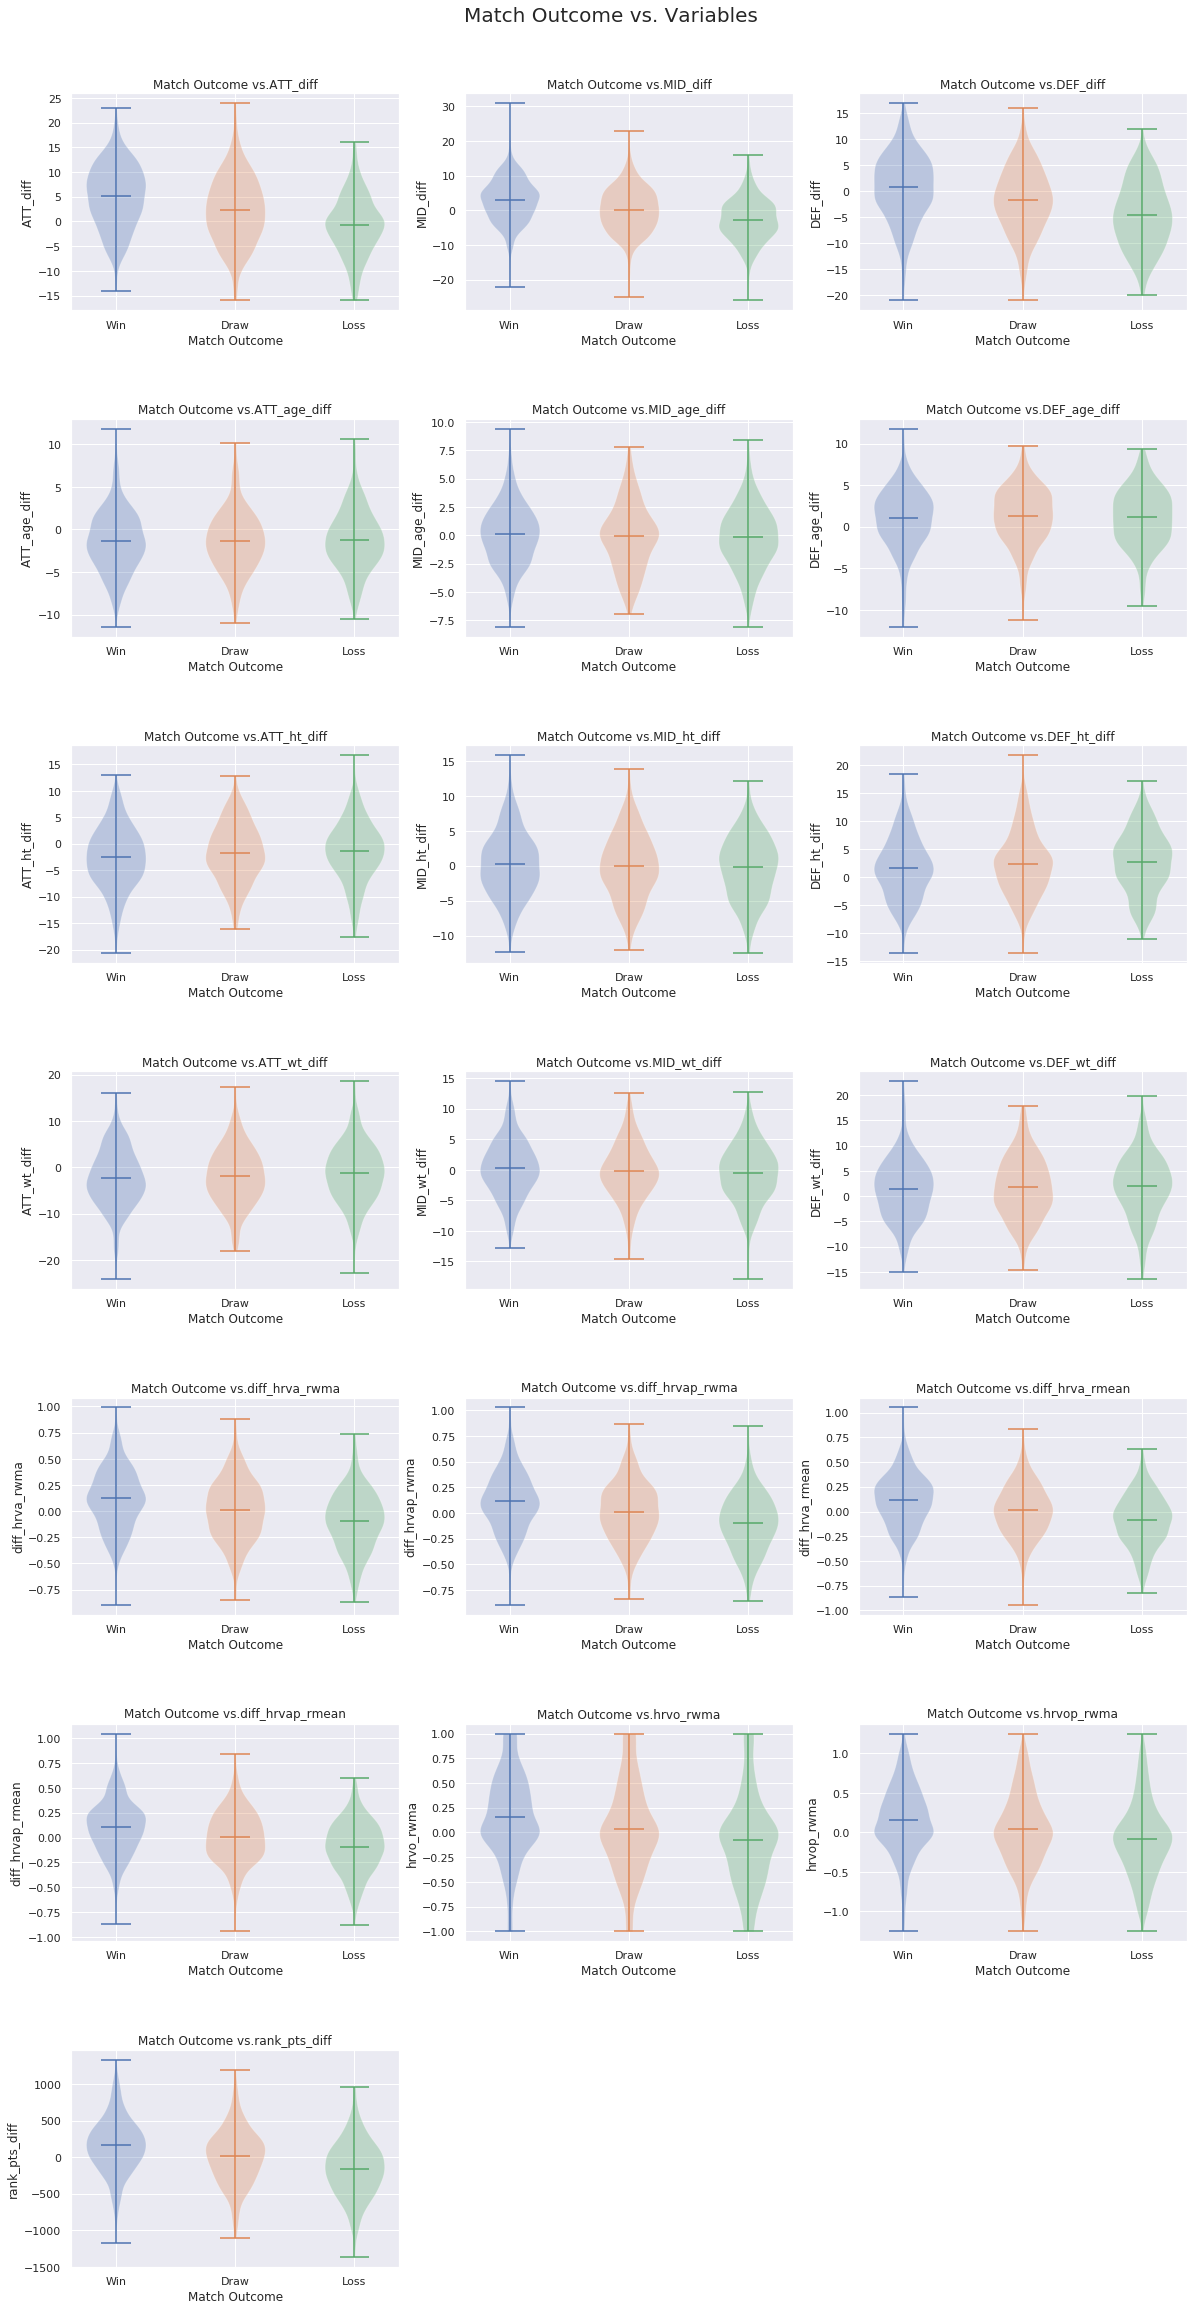

In [7]:
pos = ['W','D','L']


fig, axs = plt.subplots(7,3, figsize = (20,40))#, sharey=True)
#fig.tight_layout()
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=.2, hspace=0.5)

for col, ax in zip(num_cols,axs.ravel()):
    #los = lw.lowess(train_data['outcome_num'], train_data[col], frac = 0.3)
    #print(los)
    # now make the plots
    ax.violinplot(train_data[col][train_data['outcome'] == 'W'], [0] , vert = True, showmeans=True) 
    ax.violinplot(train_data[col][train_data['outcome'] == 'D'], [1] , vert = True, showmeans=True) 
    ax.violinplot(train_data[col][train_data['outcome'] == 'L'], [2] , vert = True, showmeans=True) 
    ax.set_xticks([y for y in range(3)])
    ax.set_xlabel('Match Outcome')
    ax.set_ylabel(col)
    ax.set_title('Match Outcome vs.' + col)
    
    #ax.setp(xticks=['Win','Draw','Loss'])
    
axs[-1, -1].axis('off')
axs[-1, -2].axis('off')
fig.suptitle('Match Outcome vs. Variables', fontsize= 20, y = 0.91)

plt.setp(axs,
         xticklabels=['Win','Draw','Loss'])
plt.show()

In [ ]:
wc_box(train_data, num_cols)

In [ ]:
import statsmodels.nonparametric.smoothers_lowess as lw

fig, axs = plt.subplots(7,3, figsize = (20,30), sharey=True)
#fig.tight_layout()
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=.2, hspace=0.5)

for col, ax in zip(num_cols,axs.ravel()):
    los = lw.lowess(train_data['outcome_num'], train_data[col], frac = 0.3)
    #print(los)
    # now make the plots
    ax.scatter(x = train_data[col], y = train_data['outcome_num'], alpha = 0.02)
    ax.plot(los[:, 0], los[:, 1], color = 'red')
    ax.set_xlabel(col)
    ax.set_ylabel('Match Outcome')
    ax.set_title('Match Outcome vs.' + col)
    
axs[-1, -1].axis('off')
axs[-1, -2].axis('off')
fig.suptitle('Match Outcome vs. Variables', fontsize= 20, y = 0.91)
plt.show()

In [ ]:
# sns.pairplot(train_data, 
#              vars = num_cols , 
#              hue="outcome_num")

In [ ]:
# setting up the correlation matrix
corrmat = train_data.corr()
f, ax = plt.subplots(figsize=(14, 10))
sns.heatmap(corrmat, vmax=.8, square=True);

**As expected, we can clearly see that there's very strong correlation between ranks and rank points. We can also see that rank and team statistics are strongly correlated so, for example, home_rank and home_OVR are strongly correlated.**

In [ ]:
#fig, ax = plt.subplots(1,1, figsize=(12,8))
#ax=sns.scatterplot(train_data.ATT_age_diff, train_data.ATT_diff, hue=train_data.outcome)

In [ ]:
for item in num_cols:
    g = sns.FacetGrid(train_data, col="outcome")
    g = (g.map(plt.hist, item, bins=15))

In [ ]:
for item in num_cols:
    g = sns.FacetGrid(train_data, col="outcome")
    g = (g.map(plt.scatter, 'rank_pts_diff', item, edgecolor='w').add_legend())

### Model Building

In [ ]:
# define the feature set for our model
predictors = ['ATT_diff', 'MID_diff', 'DEF_diff', 
              'ATT_age_diff', 'DEF_age_diff', 'MID_age_diff',
              'ATT_ht_diff', 'DEF_ht_diff', 'MID_ht_diff', 
              'ATT_wt_diff', 'DEF_wt_diff', 'MID_wt_diff',
             
              'diff_hrvap_rmean', 'hrvop_rwma'
             
             
             
             ] #'rank_pts_diff']

# scale the features
def scale_df(df, means, stds):
    cols_to_scale = means.index
    df = df.copy()
    df[cols_to_scale] = (df[cols_to_scale] - means) / stds
    return df

cols_to_scale = ['ATT_diff', 'MID_diff', 'DEF_diff', 
                 'ATT_age_diff', 'DEF_age_diff', 'MID_age_diff',
                 'ATT_ht_diff', 'DEF_ht_diff', 'MID_ht_diff', 
                 'ATT_wt_diff', 'DEF_wt_diff', 'MID_wt_diff',
                 'diff_hrvap_rmean','hrvop_rwma'
                
                ]#'rank_pts_diff']

train_means = train_data[cols_to_scale].mean(axis=0)
train_stds = train_data[cols_to_scale].std(axis=0)

train_data = scale_df(train_data, train_means, train_stds)
test_data = scale_df(test_data, train_means, train_stds)

# define x_train, y_train and x_test, y_test
x_train, y_train = train_data[predictors], train_data['outcome_num']
x_test, y_test = test_data[predictors], test_data['outcome_num']

display(x_train.describe())
display(x_test.describe())

In [ ]:
# fit logistic (ovr) regression
logreg_ovr = LogisticRegressionCV(multi_class = 'ovr', cv=5, penalty='l2')
logreg_ovr.fit(x_train, y_train)
print('Logistic Regression (OVR) Train Score: ',logreg_ovr.score(x_train, y_train))
print('Logistic Regression (OVR) CV Score: ',cross_val_score(logreg_ovr, x_train, y_train, cv=5).mean())

# fit logistic (multinomial) regression
logreg_multinomial = LogisticRegressionCV(multi_class = 'multinomial', solver='saga', cv=5, penalty='l2')
logreg_multinomial.fit(x_train, y_train)
print('Logistic Regression (Multinomial) Train Score: ',logreg_multinomial.score(x_train, y_train))
print('Logistic Regression (Multinomial) CV Score: ',cross_val_score(logreg_multinomial, x_train, y_train, cv=5).mean())

In [ ]:
# fit lda and qda 
lda = LinearDiscriminantAnalysis()
qda = QuadraticDiscriminantAnalysis()
lda.fit(x_train, y_train)
qda.fit(x_train, y_train)

print('LDA Train Score: ',lda.score(x_train, y_train))
print('LDA CV Score: ',cross_val_score(lda, x_train, y_train, cv=5).mean())
print('QDA Train Score: ',qda.score(x_train, y_train))
print('QDA CV Score: ',cross_val_score(qda, x_train, y_train, cv=5).mean())

In [ ]:
# confusion matrix for the lda model
#pd.crosstab(np.array(y_test), lda.predict(x_test), margins=True, rownames=['Actual'], colnames=['Predicted'])

In [ ]:
# confusion matrix for the qda model
#pd.crosstab(np.array(y_test), qda.predict(x_test), margins=True, rownames=['Actual'], colnames=['Predicted'])

In [ ]:
# define the list of depths we want to test
depths = list(range(1, 21))
train_scores = []
cvmeans = []
cvstds = []

for depth in depths:
    dtree = DecisionTreeClassifier(criterion='gini', max_depth=depth)
    
    # Perform 5-fold cross validation and store results
    train_scores.append(accuracy_score(y_train, dtree.fit(x_train, y_train).predict(x_train)))
    scores = cross_val_score(estimator=dtree, X=x_train, y=y_train, cv=5)
    cvmeans.append(scores.mean())
    cvstds.append(scores.std())

cvmeans = np.array(cvmeans)
cvstds = np.array(cvstds)

In [ ]:
# define the figure and axes
fig, ax = plt.subplots(1,1,figsize=(10,6))

# make the plot
ax.plot(depths, cvmeans, '*-', label="Mean CV Score", lw=3)
ax.fill_between(depths, cvmeans - 2*cvstds, cvmeans + 2*cvstds, alpha=0.3)
ax.plot(depths, train_scores, '-+', label="Train Set Score", lw=3)
ax.legend(fontsize='large')
ax.set_ylabel("Accuracy", fontsize=13)
ax.set_xlabel("Max Depth", fontsize=13)
ax.set_xticks(depths);

Training accuracy hits nearly perfect at depth 20 but we don't think that a depth-20 tree will generalize well. 
`DecisionTreeClassifier` has some randomness in it, so depending on the random choices it made, depth 2 or depth 3 trees might come out with better validation performance. We'll choose depth 3 here.

In [ ]:
# set depth to 19
best_depth = 2

# fit the tree model on test set using depth=3
dtree = DecisionTreeClassifier(criterion='gini', max_depth=best_depth)
dtree.fit(x_train, y_train)
train_score = accuracy_score(y_train, dtree.fit(x_train, y_train).predict(x_train))
test_score = accuracy_score(y_test, dtree.fit(x_train, y_train).predict(x_test))

# print out train and test scores
print('Accuracy on Train Set at depth=19: {:.2f}%'.format(train_score * 100))
print('Accuracy on Test Set at depth=19: {:.2f}%'.format(test_score * 100))

In [ ]:
# initializing variables
n_trees = 100
estimators = []
bagging_train = np.zeros((x_train.shape[0], n_trees))
bagging_test = np.zeros((x_test.shape[0], n_trees))

# conduct bootstraping iterations
for i in range(n_trees):
    simpletree = DecisionTreeClassifier(criterion='gini', max_depth=10)
    boot_xx, boot_y = resample(x_train, y_train)
    estimators.append(simpletree.fit(boot_xx, boot_y))
    bagging_train[:,i] = simpletree.predict(x_train)   
    bagging_test[:,i] = simpletree.predict(x_test)
    
#Make Predictions Dataframe
columns = ["Bootstrap-Model_"+str(i+1) for i in range(n_trees)]
bagging_train = pd.DataFrame(bagging_train, columns=columns)
bagging_test = pd.DataFrame(bagging_test, columns=columns)
display(bagging_train.head())
display(bagging_test.head())

In [ ]:
def get_prediction(df, count=-1):
    count = df.shape[1] if count==-1 else count
    temp = df.iloc[:,0:count]
    return np.mean(temp, axis=1)>0.5

bagged_train_score = accuracy_score(y_train, get_prediction(bagging_train, count=-1))
bagged_test_score = accuracy_score(y_test, get_prediction(bagging_test, count=-1))

# check accuracy of the bagged model in train and test sets
print('Training Set Accuracy: {:.2f}%'.format(bagged_train_score * 100))
print('Testing Set Accuracy: {:.2f}%'.format(bagged_test_score * 100))

In [ ]:
# confusion matrix for the bagging model
pd.crosstab(np.array(y_test), get_prediction(bagging_test, count=-1), margins=True, rownames=['Actual'], colnames=['Predicted'])

In [ ]:
# fit a Random Forest model
rforest = RandomForestClassifier(n_estimators=100, max_depth=10)
rforest.fit(x_train, y_train)

# predict
y_pred_train = rforest.predict(x_train)
y_pred_test = rforest.predict(x_test)

# performance evaluation
rf_train_score = accuracy_score(y_train, y_pred_train)
rf_test_score = accuracy_score(y_test, y_pred_test)

print("Training Set Accuracy: {:.2f}%".format(rf_train_score * 100))
print("Testing Set Accuracy: {:.2f}%".format(rf_test_score * 100))

In [ ]:
# confusion matrix for the random forest model
#pd.crosstab(np.array(y_test), rforest.predict(x_test), margins=True, rownames=['Actual'], colnames=['Predicted'])

In [ ]:
#Top Features
feature_importance = rforest.feature_importances_
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5

#Plot
plt.figure(figsize=(8,10))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, x_train.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance');

In [ ]:
# fit an Adaboost model
adaboost = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=10), n_estimators=100, learning_rate=0.05)
adaboost.fit(x_train, y_train)

# predict
y_pred_train = adaboost.predict(x_train)
y_pred_test = adaboost.predict(x_test)

# performance evaluation
train_score = accuracy_score(y_train, y_pred_train)*100
test_score = accuracy_score(y_test, y_pred_test)*100

print("Accuracy, Training Set :",str(train_score)+'%')
print("Accuracy, Testing Set :",str(test_score)+'%')

# plot iteration based score
boost_train_scores = list(adaboost.staged_score(x_train,y_train))
boost_test_scores = list(adaboost.staged_score(x_test, y_test))

fig, ax = plt.subplots(1,1,figsize=(10,6))

ax.plot(boost_train_scores, label='Train', lw=3)
ax.plot(boost_test_scores, label='Test', lw=3)
ax.set_xlabel('Iteration', fontsize=12)
ax.set_ylabel('Accuracy', fontsize=12)
ax.set_title("Variation of Accuracy with Iterations", fontsize=13)
ax.legend();

iteration = np.argmax(boost_test_scores)
print('Best iteration [{}] => {}'.format(iteration, boost_test_scores[iteration]))

In [ ]:
# confusion matrix for the adaboost model
pd.crosstab(np.array(y_test), adaboost.predict(x_test), margins=True, rownames=['Actual'], colnames=['Predicted'])

In [ ]:
kvals = list(range(10,200,10))
knn = GridSearchCV(
    KNeighborsClassifier(),
    {'n_neighbors': kvals}).fit(x_train, y_train)

best_k = knn.best_params_['n_neighbors']
print("Best k:", best_k)

best_knn_clf = KNeighborsClassifier(n_neighbors=best_k).fit(x_train, y_train)
#print('kNN Train Score:', knn.score(x_train, y_train))
#print('kNN Test Score:', knn.score(x_test, y_test))

In [ ]:
plt.plot(kvals, knn.cv_results_['mean_test_score'], '-*')
plt.fill_between(
    kvals,
    knn.cv_results_['mean_test_score'] - 2 * knn.cv_results_['std_test_score'],
    knn.cv_results_['mean_test_score'] + 2 * knn.cv_results_['std_test_score'],
    alpha=.3)
plt.xlabel('k')
plt.ylabel('validation accuracy +- 2 std');

### Model Comparison

In [ ]:
# create a list of all classifiers
named_classifiers = [
    ("Logistic Regression (OVR)", logreg_ovr),
    ("Logistic Regression (Multinomial)", logreg_multinomial),
    ("Linear Discriminant Analysis ", lda),
    ("Quadratic Discriminant Analysis", qda),
    (f"Depth-{best_depth} Decision Tree", dtree),
    ("Depth-10 Random Forest", rforest),
    ("Boosting", adaboost),
    (f"k-NN (k={best_k})", best_knn_clf),
]

In [ ]:
# run cross-validation on all models
cv_scores = [
    cross_val_score(clf, x_train, y_train, cv=5, n_jobs=-1)
    for name, clf in named_classifiers
]

In [ ]:
# visualize CV accuracy for each of the models
positions = np.arange(len(named_classifiers))
plt.boxplot(cv_scores, vert=False, positions=positions);
plt.yticks(positions, [name for name, model in named_classifiers])
plt.ylabel("Classifier")
plt.xlabel("Validation-Set Accuracy");

In [ ]:
# summarize the above results in a table
performance_estimates = pd.DataFrame([
    [scores.mean(), scores.std()] for scores in cv_scores
], index=[name for name, model in named_classifiers], columns=["cv_accuracy", "cv_std"])

performance_estimates.sort_values('cv_accuracy')

**From the above table, we can see that Logistic Regression (Multinomial) model performs best on the validation set. Now, let's evaluate each fitted model's performance on the test set.**

In [ ]:
performance_estimates.assign(test_accuracy=[
        accuracy_score(y_test, clf.predict(x_test))
        for name, clf in named_classifiers]).sort_values('test_accuracy')

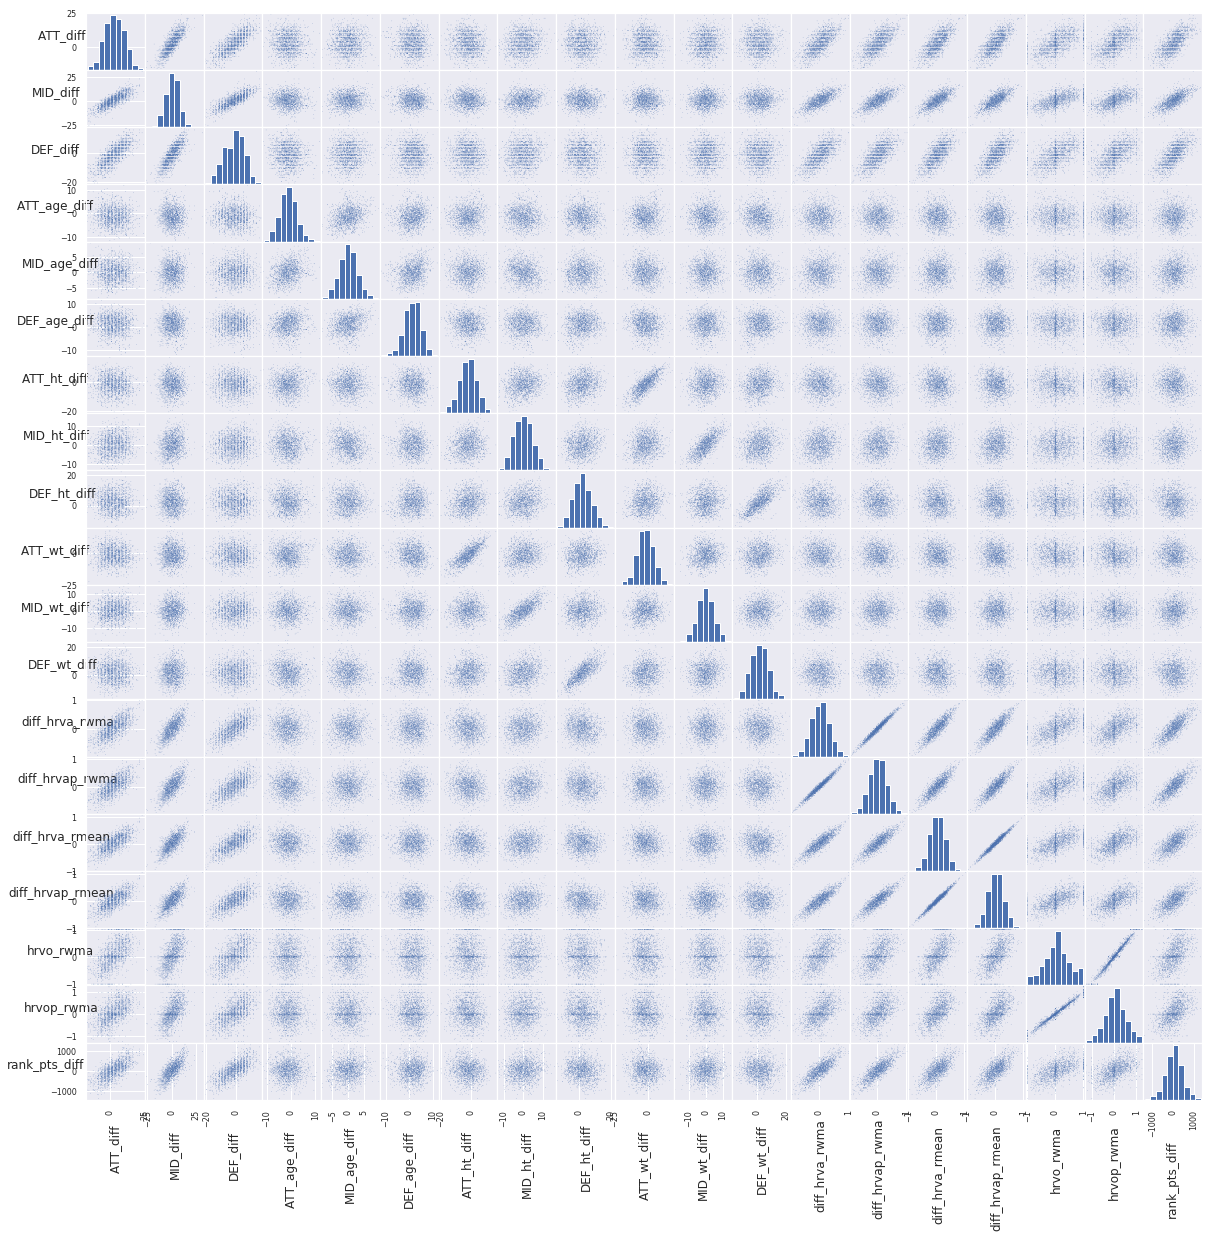

In [8]:
cols = num_cols.copy()

cols.append('outcome_num')

scatter_matrix = pd.plotting.scatter_matrix(train_data[num_cols],
    figsize  = [20, 20],
    marker   = ".",
    s        = 1,
    diagonal = "hist",
    alpha = 1
)

for ax in scatter_matrix.ravel():
    ax.set_xlabel(ax.get_xlabel(), fontsize = 12, rotation = 90)
    ax.set_ylabel(ax.get_ylabel(), fontsize = 12, rotation = 0)